In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

In [ ]:
import h5py
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Flatten, Dense, Reshape, Conv3DTranspose, BatchNormalization, Embedding, Multiply, Concatenate

from tensorflow.keras.models import Model, Sequential

In [ ]:
img_x = 32
img_y = 32
img_z = 32
channels = 1

# 입력 이미지 차원
img_shape = (img_x, img_y, img_z, channels)

# 생성자 입력으로 사용될 잡음 벡터 크기
latent_dim = 100

In [2]:
def build_discriminator(img_shape):
    # 입력 이미지 shape : input_shape
    input_image = Input(shape=img_shape)

    # Convolutional layers
    x = Conv3D(32, (3, 3, 3), strides=(2, 2, 2), padding='same')(input_image)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv3D(64, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv3D(128, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv3D(256, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Flatten
    x = Flatten()(x)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # 모델 생성
    model = tf.keras.Model(inputs=input_image, outputs=output, name='discriminator')

    return model

In [ ]:
def build_generator(z_dim):
    input_layer = Input(shape=z_dim)
    x = Dense(512*4*4*4, use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((4, 4, 4, 512))(x)
    x = Conv3DTranspose(256, (3, 3, 3), strides=(2, 2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv3DTranspose(128, (3, 3, 3), strides=(2, 2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv3DTranspose(1, (3, 3, 3), strides=(1, 1, 1), padding='same', use_bias=False, activation='tanh')(x)
    model = tf.keras.Model(input_layer, x)
    return model

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(z_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048, 3)]         0         
                                                                 
 dense (Dense)               (None, 2048, 64)          256       
                                                                 
 dense_1 (Dense)             (None, 2048, 128)         8320      
                                                                 
 dense_2 (Dense)             (None, 2048, 1024)        132096    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 1024)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                             

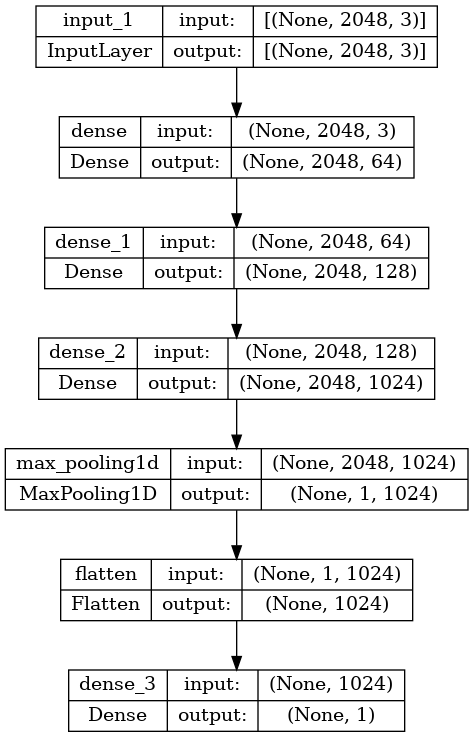

In [3]:
from tensorflow.keras.utils import plot_model

discriminator.summary()
plot_model(discriminator, show_shapes=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 dense_7 (Dense)             (None, 6144)              6297600   
                                                                 
 reshape (Reshape)           (None, 2048, 3)           0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 2048, 64)         832 

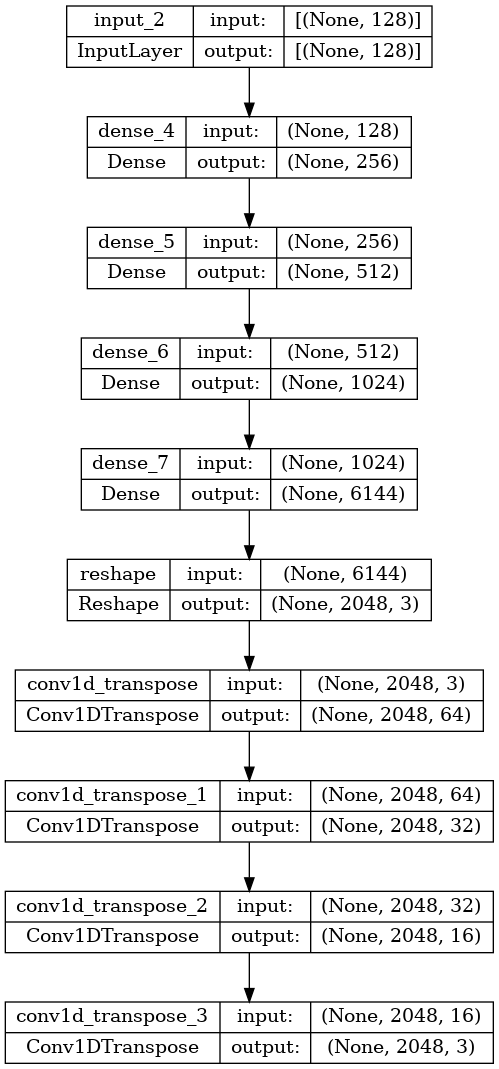

In [5]:
from tensorflow.keras.utils import plot_model

generator.summary()
plot_model(generator, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048, 3)           6998835   
                                                                 
 model (Functional)          (None, 1)                 141697    
                                                                 
Total params: 7,140,532
Trainable params: 7,140,532
Non-trainable params: 0
_________________________________________________________________


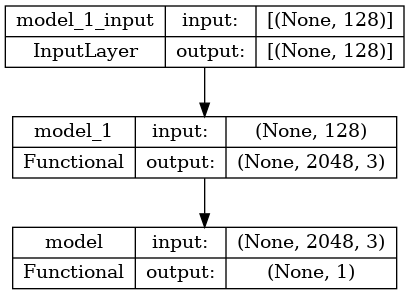

In [7]:
gan.summary()
plot_model(gan, show_shapes=True)

In [8]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [9]:
import h5py

# Open the file
with h5py.File('/home/yoobh/ws/MastersThesis/airplane_pcd_2048_230508_01.h5', 'r') as f:
    data = f['data'][:-18]

print("Data shape:", data.shape)

# Batch the data and shuffle
batch_size = 32

# Specify the dtype of the data
dtype = tf.float32

# Convert the data array to a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices(tf.cast(data, dtype=dtype))
dataset = dataset.shuffle(buffer_size=len(data)).batch(batch_size)

print(dataset.element_spec)

Data shape: (608, 2048, 3)
TensorSpec(shape=(None, 2048, 3), dtype=tf.float32, name=None)


In [13]:
import numpy as np

def train_gan(gan, dataset, batch_size, latent_dim, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, latent_dim])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, latent_dim])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        num_samples = 20
        random_noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
        generated_samples = generator(random_noise)
        filename = f'generated_sample_{epoch + 1}.npy'
        np.save(filename, generated_samples)

In [14]:
train_gan(gan, dataset, batch_size, latent_dim, n_epochs=50)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [ ]:
checkpoint = tf.train.Checkpoint(model=generator)
checkpoint.save("generator.ckpt")

In [ ]:
discriminator.save('pcd2048_40_230507_01_discriminator.h5')
generator.save('pcd2048_40_230507_01_generator.h5')
gan.save('pcd2048_40_230507_01_gan.h5')

In [ ]:
import matplotlib.pyplot as plt

num_samples = 20
random_noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
generated_samples = generator(random_noise)

# 시각화에 필요한 변수 설정
num_row = 4
num_col = 5

# 생성된 샘플들 중 일부만 선택
selected_samples = generated_samples[:num_row * num_col]

# 시각화할 전체 그림 크기 설정
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Generated Samples', fontsize=20) # 전체 제목 설정


# 각 셀에 3D 볼륨을 시각화하여 배치
for i in range(num_row * num_col):
    # 현재 셀 위치 계산
    ax = fig.add_subplot(num_row, num_col, i+1, projection='3d')
    
    # 3D 볼륨 시각화
    ax.voxels(selected_samples[i, :, :, :, 0], edgecolor='k')
    ax.set(xticks=[], yticks=[], zticks=[])
    ax.set_title(f'Sample {i+1}')

# 그림 출력
plt.tight_layout()
plt.show()


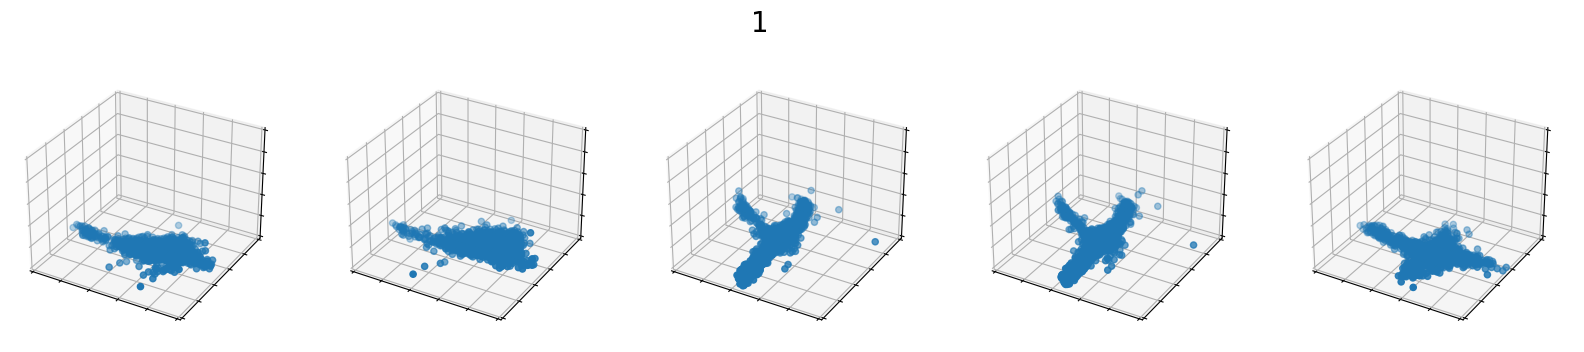

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

load_pcd = np.load('./generated_pcd_500.npy')
# 데이터와 라벨 로드
data = load_pcd
# label = load_pcd['label']

# subplot 행과 열 설정
num_plots_row = 1
num_plots_col = 5

# 전체 플롯 설정
fig = plt.figure(figsize=(20, 4))
fig.suptitle('1', fontsize=20) # 전체 제목 설정

# 각각의 subplot 생성
for i in range(num_plots_row*num_plots_col):
    ax = fig.add_subplot(num_plots_row, num_plots_col, i+1, projection='3d')
    plot_data = data[i]
    # plot_label = label[i]
    
    # scatter plot 생성
    ax.scatter(plot_data[:, 0], plot_data[:, 1], plot_data[:, 2])
    # 축 범위 설정
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    # 축 옆의 숫자 없애기
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    # # 제목 설정
    # label_name = list(categories.keys())[list(categories.values()).index(plot_label[0])]
    # plt.title(f'{label_name}')
    
# 플롯 보여주기
plt.show()

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

for n in range(500):
    filenum = n + 1
    load_pcd = np.load(f'./generated_pcd_{filenum}.npy')
    # 데이터와 라벨 로드
    data = load_pcd
    # label = load_pcd['label']

    # subplot 행과 열 설정
    num_plots_row = 1
    num_plots_col = 5

    # 전체 플롯 설정
    fig = plt.figure(figsize=(20, 4))
    fig.suptitle(f'Epoch {filenum}/500', fontsize=20) # 전체 제목 설정

    # 각각의 subplot 생성
    for i in range(num_plots_row*num_plots_col):
        ax = fig.add_subplot(num_plots_row, num_plots_col, i+1, projection='3d')
        plot_data = data[i]
        # plot_label = label[i]
        
        # scatter plot 생성
        ax.scatter(plot_data[:, 0], plot_data[:, 1], plot_data[:, 2])
        # 축 범위 설정
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_zlim([0, 1])
        # 축 옆의 숫자 없애기
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        
        # # 제목 추가
        # ax.set_title(f"Label: {plot_label[0]}")
        # # 제목 설정
        # label_id = np.argmax(label[i])
        # label_name = list(categories.keys())[list(categories.values()).index(label_id)]
        # plt.title(f'{label_name}')
        
    # # 플롯 보여주기
    # plt.show()
    # 그래프 저장
    plt.savefig(f"Epoch{filenum}.png")
    plt.clf()
    plt.close()
    print(filenum)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [7]:
import imageio
import os

# 이미지 파일 경로 설정
img_dir = '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/'

# 이미지 파일 리스트 생성
# img_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')]
img_files = []

for i in range(500):
    filenum = i + 1
    file_name = f"Epoch{filenum}.png"
    file_path = os.path.join(img_dir, file_name)
    img_files.append(file_path)

In [5]:
# img_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')])

In [8]:
img_files

['/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch1.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch2.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch3.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch4.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch5.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch6.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch7.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch8.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch9.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch10.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch11.png',
 '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/Epoch12.png',
 '/home/yoobh/ws/MastersThesis/ModelN

In [13]:
# 이미지 시퀀스를 영상으로 변환
with imageio.get_writer('output.mp4', fps=5) as writer:
    for img_file in img_files:
        img = imageio.imread(img_file)
        writer.append_data(img, duration=0.2)

/tmp/ipykernel_21060/3442498892.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_file)


TypeError: Format.Writer.append_data() got an unexpected keyword argument 'duration'

In [16]:
# 이미지 시퀀스를 영상으로 변환
images = []
for img_file in img_files:
    images.append(imageio.imread(img_file))

# 영상 파일로 저장
imageio.mimsave('output3.mp4', images, fps=5)

/tmp/ipykernel_21060/188805453.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_file))
